<a href="https://colab.research.google.com/github/codeSamuraii/ml-experiments/blob/main/CompressionDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# JPEG Compression detection with Keras
The objective of this notebook is to train a machine learning model to recognise images that have been compressed using a lossy algorithm (such as JPEG) from original high-quality ones.


## Fetching and preparing the dataset files
We'll use a landscape images dataset from Kaggle.

_You'll need a Kaggle account to download the dataset._


In [38]:
import getpass

kaggle_ids = getpass.getpass('Content of your ~/.kaggle/kaggle.json: ')
os.environ['KAGGLE_JSON'] = kaggle_ids

!mkdir ~/.kaggle; echo $KAGGLE_JSON > ~/.kaggle/kaggle.json; chmod 600 ~/.kaggle/kaggle.json

Content of your ~/.kaggle/kaggle.json: ··········


Download the dataset:

In [36]:
!mkdir /content/dataset; kaggle datasets download -d arnaud58/landscape-pictures -p /content/dataset --unzip

100% 620M/620M [00:29<00:00, 22.5MB/s]
100% 620M/620M [00:29<00:00, 22.2MB/s]


Compress the images using Pillow, and put them in separate folders under `training`, one for `compressed` images, one for `quality` images:

In [3]:
!cd /content; rm -rf training; mkdir training; mkdir training/compressed; mkdir training/quality

import os
import pathlib
import tensorflow as tf
from PIL import Image
from itertools import chain


# Images have different extensions
folder = pathlib.Path('dataset')
extensions = {'*.jpg', '*.jpeg'}
images = list(chain.from_iterable(folder.glob(ext) for ext in extensions))
nb_img, nb_errors = len(images), 0
print(f'Found {nb_img} images.')

for i, image_file in enumerate(images):
    try:
        im = Image.open(image_file, formats=['JPEG'])
        im.save(f'training/quality/{i}.jpg', optimize=True, quality='keep')
    except (OSError, ValueError):
        nb_errors += 1
        continue

    im.save(f'training/compressed/{i}.jpg', optimize=False, quality=10)

    if i % 1000 == 0:
        progress = int(i / nb_img * 100)
        print(f'{progress}% ({i}/{nb_img} E={nb_errors})')

print('Done.')

Found 4319 images.
0% (0/4319 E=0)
23% (1000/4319 E=0)
46% (2000/4319 E=0)
69% (3000/4319 E=0)
92% (4000/4319 E=0)
Done.


## Splitting the dataset
Now that we have created our compressed images, let's use Keras to split the dataset between training and validation. Keras will understand that each subdirectory of `training` is a class we're trying to predict.

In [4]:
import tensorflow as tf


batch_size = 16
img_height = 1000
img_width = 1000

train_dataset = tf.keras.utils.image_dataset_from_directory(
  'training',
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  crop_to_aspect_ratio=True,
  # label_mode='binary',
  batch_size=batch_size
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
  'training',
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  crop_to_aspect_ratio=True,
  # label_mode='binary',
  batch_size=batch_size
)

class_names = train_dataset.class_names
num_classes = len(class_names)
print(f'{num_classes} classes: {class_names}')

Found 8638 files belonging to 2 classes.
Using 6911 files for training.
Found 8638 files belonging to 2 classes.
Using 1727 files for validation.
2 classes: ['compressed', 'quality']


Note that the dataset has been configured to perform a _categorical_ classification.

It is suited for classifications with two or more classes. The output will be the computed probability for an image to belong to each class: `[0.97, 0.03]` for example.

> Considering we are only trying to predict if an image is compressed or not, we could have used a _binary_ classification, which would only output "yes" (`1`) or "no" (`0`). For that we would need to uncomment `label_mode='binary'` and modify the model's output layer.

We check that pictures have been assigned to the correct label:

Pixel values in [0.0:255.0]


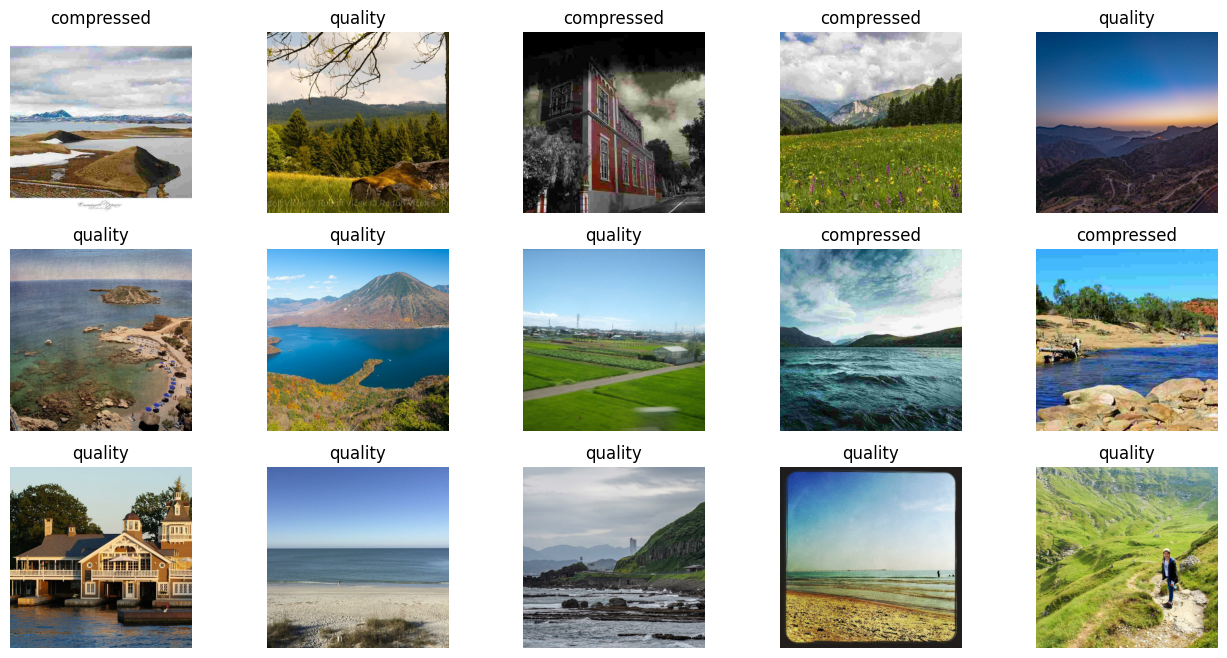

In [39]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
for images, labels in train_dataset.take(1):
  for i in range(15):
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

image_batch, _ = next(iter(train_dataset))
first_image = image_batch[0]
print(f'Pixel values in [{np.min(first_image)}:{np.max(first_image)}]')


We can see that compressed images have artifacts, especially in gradient areas like the sky. Our model should be able to pick up these details.

## Create the model and train
We create a basic CNN network made of convolutions and pooling layers increasing in filter size.

To prevent overfitting, the images go through preprocessing layers where data augmentation operations are performed like flip and zoom. A dropout layer after the convolutions helps further.

Data is rescaled to the `[0: 100]` range during that process as it is common when using RGB data.

We also put in place checkpoint and early stopping callbacks that will stop the training prematurely if performance drops and restore the best weights.

> For a *binary* classification, we simply need to change the output layer's dimension to `1` and use a *binary crossentropy* loss function.

In [6]:
import tempfile
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


preprocess = keras.Sequential([
    # Augmentation
    layers.RandomFlip(input_shape=(img_height, img_width, 3)),
    layers.RandomZoom((0.0, 0.2)),
    layers.RandomRotation(0.1, fill_mode='constant'),
    # Rescaling
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
])


model = Sequential([
  preprocess,

  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Dropout(0.2),

  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')  # layers.Dense(1, activation='sigmoid')
])


model.compile(optimizer='Adamax',
              loss='sparse_categorical_crossentropy',  # loss='binary_crossentropy',
              metrics=['accuracy'])


_, checkpoint_file = tempfile.mkstemp(prefix='checkpoint_', suffix='.keras', dir='/tmp')
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_file, save_best_only=True)
early_stop = tf.keras.callbacks.EarlyStopping(start_from_epoch=10, patience=6, restore_best_weights=True)

history = model.fit(train_dataset, epochs=30, validation_data=validation_dataset, callbacks=[checkpoint, early_stop])

loss, accuracy = model.evaluate(validation_dataset)
print("Loss: ", loss)
print("Accuracy: ", accuracy)



Epoch 1/30
432/432 [==============================] - 56s 130ms/step - loss: 1.4515 - accuracy: 0.5093
Epoch 2/30
432/432 [==============================] - 56s 130ms/step - loss: 0.6937 - accuracy: 0.5137 - val_loss: 0.6878 - val_accuracy: 0.5402
Epoch 3/30
432/432 [==============================] - 56s 130ms/step - loss: 0.6896 - accuracy: 0.5297 - val_loss: 0.6792 - val_accuracy: 0.5402

* snip *

Epoch 22/30
432/432 [==============================] - 54s 124ms/step - loss: 0.1204 - accuracy: 0.9495 - val_loss: 0.1738 - val_accuracy: 0.9270
Epoch 23/30
432/432 [==============================] - 53s 123ms/step - loss: 0.1159 - accuracy: 0.9528 - val_loss: 0.1219 - val_accuracy: 0.9502
Epoch 24/30
432/432 [==============================] - 56s 129ms/step - loss: 0.1117 - accuracy: 0.9543 - val_loss: 0.0834 - val_accuracy: 0.9624
Epoch 25/30
432/432 [==============================] - 54s 123ms/step - loss: 0.0983 - accuracy: 0.9588 - val_loss: 0.0882 - val_accuracy: 0.9624
Epoch 26/30


We can see the model wasn't improving after epoch 24, weights have therefore been restored to that training step.

## Review performance

Let's plot the training statistics :

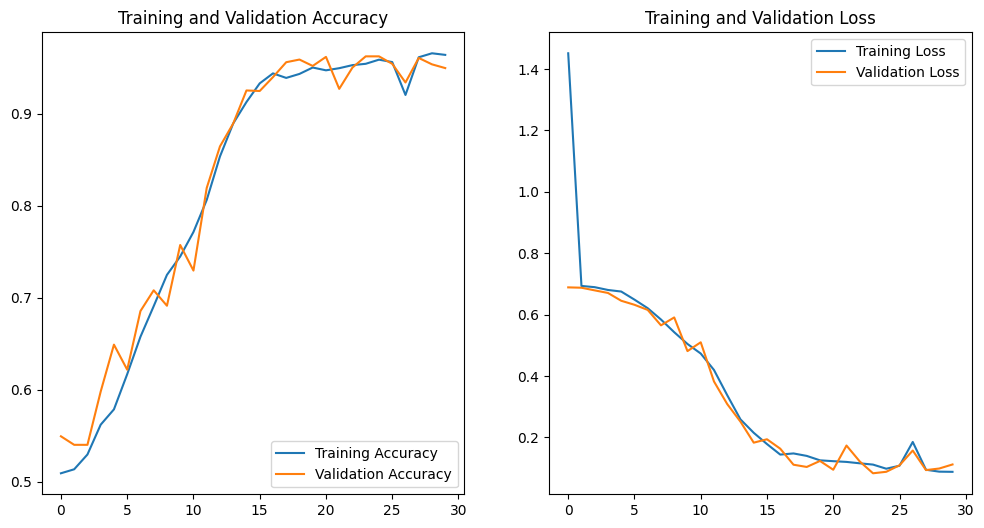

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

nb_epochs = len(history.history['val_loss'])
epochs_range = range(nb_epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


We can see that there was no overfitting and validation loss nicely follows training.

## Save the model
Let's save our model, we can use it for predictions straight away or for reinforcement learning.

In [14]:
print("Saving model...")
_, model_file = tempfile.mkstemp(prefix=f'trained_{int(accuracy * 100)}_', suffix='.keras', dir='/content')
tf.keras.models.save_model(model, model_file)

print("Saved to: ", model_file)

Saving model...
Saved to:  /content/trained_96_bqfcxv8f.keras


## Make some predictions
Let's try some random predictions :

In [16]:
import numpy as np
from random import randint, choice

# 100 random predictions
for i in range(100):
    rand_class = choice(class_names)
    rand_file = f'training/{rand_class}/{randint(0,1000)}.jpg'
    img = tf.keras.utils.load_img(rand_file, target_size=(img_height, img_width))

    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array, verbose=False)
    score = tf.nn.softmax(predictions[0])

    pred_class, pred_confidence = class_names[np.argmax(score)], 100 * np.max(score)
    if pred_class != rand_class:
        print(f'FAIL - input: {rand_class} > pred: {pred_class} ({pred_confidence:.2f}) - {rand_file}')


FAIL - input: quality > pred: compressed (57.78) - training/quality/44.jpg
FAIL - input: compressed > pred: quality (61.74) - training/compressed/511.jpg


We can see that our model performs decently. When it fails to predict the right answer, the confidence score is low (~60%). In a real application, we could filter results with a minimum score.

# Improving generalization with transfer learning
Our current model is able to differentiate compressed _landscape_ images from original ones. However, it wouldn't perform well with a different kind of picture.

Using transfer learning and a different set of pictures, we'll improve our model ability to generalize.

## Creating a new model from the previous one
We'll first load the model we want to use as a base for our transfer learning, connect new dense layers (discarding the base model's final prediction layer) and freeze already trained layers with `layer.trainable=False`.

In [34]:
from keras.models import load_model, Model

base_model = load_model(model_file)

# We discard the last layer
new_model = base_model.layers[len(base_model.layers) - 2].output

# We add new dense layers
new_model = layers.Dense(64)(new_model)
new_model = layers.Dense(64)(new_model)
new_model = layers.Dense(num_classes, activation='softmax')(new_model)
new_model = Model(inputs=base_model.input, outputs=new_model)

# We freeze every layer except the last three we just added
for i in range(len(new_model.layers) - 3):
    new_model.layers[i].trainable = False

new_model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_input (InputLay  [(None, 1000, 1000, 3)]   0         
 er)                                                             
                                                                 
 sequential (Sequential)     (None, 1000, 1000, 3)     0         
                                                                 
 conv2d (Conv2D)             (None, 1000, 1000, 16)    448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 500, 500, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 500, 500, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 250, 250, 32)      0   

Let's verify that the layers are configured properly:

In [33]:
for i in range(14):
    print(f'{i}: {new_model.layers[i].__class__.__name__} - {new_model.layers[i].trainable}')

0: InputLayer - False
1: Sequential - False
2: Conv2D - False
3: MaxPooling2D - False
4: Conv2D - False
5: MaxPooling2D - False
6: Conv2D - False
7: MaxPooling2D - False
8: Dropout - False
9: Flatten - False
10: Dense - False
11: Dense - True
12: Dense - True
13: Dense - True
